In [17]:
from typing import Tuple

import time
import threading

import matplotlib.pyplot as plt
import cv2
import numpy as np
from scipy import ndimage, stats
from IPython.display import display, Image
import ipywidgets as widgets

from starpusher import Starpusher

In [2]:
DEVICE_IP = "10.1.1.2"
UDP_PORT = 6868

LED_PORT = 1
LEDS_PER_PORT = 100

sp = Starpusher(DEVICE_IP, UDP_PORT, gamma_corrected=True)

BUFFER = [(0,0,0) for _ in range(LEDS_PER_PORT)]

def set_pixel(index: int, color: Tuple[int, int, int]) -> None:
    for i in range(len(BUFFER)):
        BUFFER[i] = (0, 0, 0)
    BUFFER[index] = color
    sp.send(LED_PORT, BUFFER)

In [3]:
class VideoCapture:
    def __init__(self, name):
        self.cap = cv2.VideoCapture(name)
        self.lock = threading.Lock()
        self.t = threading.Thread(target=self._reader)
        self.t.daemon = True
        self.latest_frame = None
        self.t.start()

    # grab frames as soon as they are available
    def _reader(self):
        while True:
            ret = self.cap.grab()
            _, latest_frame = self.cap.retrieve()
            with self.lock:
                self.latest_frame = latest_frame
            if not ret:
                break

    # retrieve latest frame
    def read(self):
        return np.array(self.latest_frame, dtype="int16")

cap = VideoCapture(1)
time.sleep(1)

ToggleButton(value=False, button_style='danger', description='Stop', icon='square', tooltip='Description')

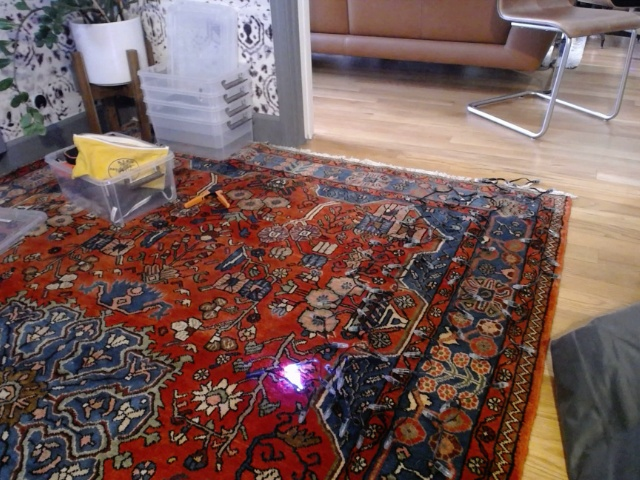

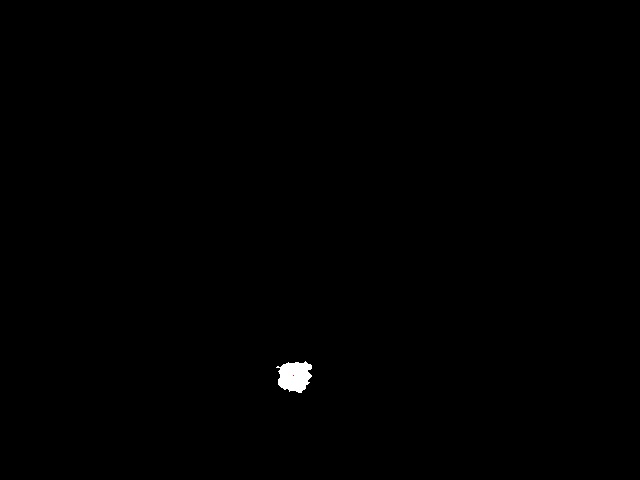

In [51]:
stopButton = widgets.ToggleButton(
    value=False,
    description='Stop',
    disabled=False,
    button_style='danger', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Description',
    icon='square' # (FontAwesome names without the `fa-` prefix)
)


LED_CHANGE_WAIT_TIME_SECONDS = 0.2

rchan = 2
gchan = 1
bchan = 0

BRIGHTNESS = 255

BLACK = (0, 0, 0)
RED = (BRIGHTNESS, 0, 0)
GREEN = (0, BRIGHTNESS, 0)
BLUE = (0, 0, BRIGHTNESS)
WHITE = (BRIGHTNESS, BRIGHTNESS, BRIGHTNESS)

def to_grayscale(frame):
    return 0.3 * frame[:, :, 2] + 0.59 * frame[:, :, 1] + 0.11 * frame[:, :, 0]

pixel_positions = {}

def view(button):
    global index
    
    display_handle = display(None, display_id=True)
    display_handle2 = display(None, display_id=True)
    for index in range(20, LEDS_PER_PORT):
        set_pixel(index, BLACK)
        time.sleep(LED_CHANGE_WAIT_TIME_SECONDS)
        off_frame = cap.read()

        set_pixel(index, WHITE)
        time.sleep(LED_CHANGE_WAIT_TIME_SECONDS)
        white_frame = cap.read()        
        
        #set_pixel(index, RED)
        #time.sleep(LED_CHANGE_WAIT_TIME_SECONDS)
        #red_frame = cap.read()
        
        #set_pixel(index, GREEN)
        #time.sleep(LED_CHANGE_WAIT_TIME_SECONDS)
        #green_frame = cap.read()

        #set_pixel(index, BLUE)
        #time.sleep(LED_CHANGE_WAIT_TIME_SECONDS)        
        #blue_frame = cap.read()

        #red_green_diff = green_frame - red_frame
        #red_blue_diff = blue_frame - red_frame

        #red_to_green_changes = (red_green_diff[:, :, rchan] < -100) & (red_green_diff[:, :, gchan] > 100)

        #diff_frame = np.zeros(red_frame.shape)
        #diff_frame[red_green_diff[:, :, gchan] > 20, 0] = 255
        #diff_frame[red_green_diff[:, :, rchan] < -20, 2] = 255
        #diff_frame[red_blue_diff[:, :, bchan] > 20, 1] = 255
        _, frame = cv2.imencode('.jpeg', white_frame)
        display_handle.update(Image(data=frame.tobytes()))

        
        white_off_diff = to_grayscale(white_frame) - to_grayscale(off_frame)

        white_off_diff[white_off_diff[:, :] < 0] = 0

        #on_off_frame = np.zeros(white_off_diff.shape)

        #negative_changes_mask = white_off_diff[:, :] < 0
        #positive_changes_mask = white_off_diff[:, :] >=1
        #on_off_frame[negative_changes_mask, 0] = abs(white_off_diff[negative_changes_mask])
        #on_off_frame[positive_changes_mask, 1] = white_off_diff[positive_changes_mask]

        blurred_on_off_frame = ndimage.gaussian_filter(white_off_diff, 1.0)
        labels, nr_objects = ndimage.label(blurred_on_off_frame > 50)

        
        largest_label, _ = stats.mode(labels[labels != 0], None)
        center = ndimage.center_of_mass(white_off_diff, labels, largest_label)

        labeled_frame = np.zeros(white_frame.shape)
        labeled_frame[labels == largest_label, :] = 255
        labeled_frame[int(center[0]), int(center[1]), :] = [0, 0, 255]
        pixel_positions[index] = center
        
        _, frame = cv2.imencode('.jpeg', labeled_frame)
        display_handle2.update(Image(data=frame.tobytes()))        

        
        if stopButton.value:
            return
        #    cap.release()
        #    display_handle.update(None)
            
display(stopButton)
thread = threading.Thread(target=view, args=(stopButton,))
thread.start()

In [52]:
pixel_positions

{20: (470.464455535747, 449.50111864676035),
 21: (411.7268067208303, 417.4526703740682),
 22: (417.346779092566, 437.7424022556305),
 23: (380.0972222845044, 562.4001979002165),
 24: (357.1645633554673, 459.0800127235364),
 25: (356.02564079288163, 536.7823155210195),
 26: (307.9843839384122, 499.53942107766),
 27: (303.4794057417152, 496.20363518800616),
 28: (289.39243240886043, 511.7261189475349),
 29: (280.45724433828445, 564.7084693105877),
 30: (269.96191259652454, 560.5747194033794),
 31: (240.3135852192814, 515.4101074031454),
 32: (237.0891758914592, 556.0252142976527),
 33: (216.7358534618072, 511.92279651182474),
 34: (210.86515750305458, 557.2369565977941),
 35: (195.1969520106023, 510.5903581766819),
 36: (191.95591956099048, 554.6763551759125),
 37: (185.7938738654157, 507.5778102867172),
 38: (182.743900440481, 539.501657522908),
 39: (183.3903634378521, 506.25230658680977),
 40: (180.13312608635135, 480.08308771829644),
 41: (181.0205320767807, 479.29863465529627),
 42

In [ ]:
height_above_floor = 860.0
distance_to_last_index = 1144.0

In [55]:
import json

coords = []

for index in sorted(pixel_positions):
    x, y = pixel_positions[index]
    coords.append({
        "x": x,
        "y": y,
        "z": 0,        
    })

fixture = {
    "label": "Xmas Tree Test",
    "components": [
        {"type": "points", "coords": coords},
    ],
}
print(json.dumps(fixture, indent=4))


{
    "label": "Xmas Tree Test",
    "components": [
        {
            "type": "points",
            "coords": [
                {
                    "x": 470.464455535747,
                    "y": 449.50111864676035,
                    "z": 0
                },
                {
                    "x": 411.7268067208303,
                    "y": 417.4526703740682,
                    "z": 0
                },
                {
                    "x": 417.346779092566,
                    "y": 437.7424022556305,
                    "z": 0
                },
                {
                    "x": 380.0972222845044,
                    "y": 562.4001979002165,
                    "z": 0
                },
                {
                    "x": 357.1645633554673,
                    "y": 459.0800127235364,
                    "z": 0
                },
                {
                    "x": 356.02564079288163,
                    "y": 536.7823155210195,
                 